# What Is the Top Complaint Type?

The goal of this exercise is to find the answer to the Question 1 of the problem statement:

> Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?

In this exercise, you need to read back the 311 datasets that you stored in Cloud Object Store and explore the dataset.

By the end of this exercise, you need to figure out the correct Complaint Type that the Department of Housing Preservation and Development of New York City should focus on.

# Import the data and prepare for analysis

In this section we first load the data set from the IBM cloud or a local csv file and then check it and prepare for analysis. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ibm_boto3

from botocore.client import Config

In [2]:
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
SECURITY_DUMMY = '----------------'
erm2_nwe9_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'erm2_nwe9.csv'
}

# Here we check if the credentials are present, if not try 
# load the local file if they are then read from the cloud.
if erm2_nwe9_creds.get('IAM_SERVICE_ID') == SECURITY_DUMMY :
    # This is the alternative to get the code run locally with a local csv file
    body = 'data' + os.path.sep + 'erm2_nwe9.csv'
else :
    # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
    # You might want to remove those credentials before you share the notebook.
    client = ibm_boto3.client(
        service_name = 's3',
        ibm_api_key_id = erm2_nwe9_creds.get('IBM_API_KEY_ID'),
        ibm_auth_endpoint = erm2_nwe9_creds.get('IBM_AUTH_ENDPOINT'),
        config = Config(signature_version='oauth'),
        endpoint_url = erm2_nwe9_creds.get('ENDPOINT'))
    
    #Read the body from the client
    body = client.get_object(
        Bucket = erm2_nwe9_creds.get('BUCKET'),
        Key = erm2_nwe9_creds.get('FILE'))['Body']
    
    # add missing __iter__ method, so pandas accepts body as file-like object
    def __iter__(self): return 0
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
        
print(body)

data/erm2_nwe9.csv


Let us now read the CSV file and then take a look at its structure:

In [3]:
# Read the CSV file
dhp_df = pd.read_csv(body, parse_dates = ['created_date', 'closed_date'])
dhp_df.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,location_type,status,closed_date
0,2020-02-16 23:44:19,45631575,HEAT/HOT WATER,10455.0,511 EAST 148 STREET,EAST 148 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.814174,-73.915020,RESIDENTIAL BUILDING,Open,NaT
1,2020-02-16 08:58:39,45630120,HEAT/HOT WATER,11218.0,483 OCEAN PARKWAY,OCEAN PARKWAY,ADDRESS,BROOKLYN,The complaint you filed is a duplicate of a co...,BROOKLYN,40.636830,-73.972855,RESIDENTIAL BUILDING,Open,NaT
2,2020-02-16 15:33:26,45628166,HEAT/HOT WATER,11230.0,788 EAST 10 STREET,EAST 10 STREET,ADDRESS,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,40.630019,-73.967198,RESIDENTIAL BUILDING,Closed,2020-02-16 18:07:11
3,2020-02-16 20:34:31,45628140,HEAT/HOT WATER,10033.0,495 WEST 186 STREET,WEST 186 STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.851105,-73.928444,RESIDENTIAL BUILDING,Open,NaT
4,2020-02-16 19:58:18,45632880,HEAT/HOT WATER,10030.0,111 WEST 141 STREET,WEST 141 STREET,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.818152,-73.938661,RESIDENTIAL BUILDING,Open,NaT


Since we are asked to analyze the complaints before the 31st of December 2018 we shall check that the *'created_date'* column of the data frame has the right type, i.e. *datetime64*. The conversion has already been done when the data was gathered from the web resource.

In [4]:
# Investigate the dolumn types, the created_date has a proper datetime64 format
dhp_df.dtypes

created_date              datetime64[ns]
unique_key                         int64
complaint_type                    object
incident_zip                     float64
incident_address                  object
street_name                       object
address_type                      object
city                              object
resolution_description            object
borough                           object
latitude                         float64
longitude                        float64
location_type                     object
status                            object
closed_date               datetime64[ns]
dtype: object

Now let us only consider the complaints submitted before *'2018-12-31'*:

In [5]:
# Now we can select the list of complains created before the 31st Dec 2018
max_date = np.datetime64('2018-12-31')
sel_comp_df = dhp_df[dhp_df['created_date'] <= max_date][['complaint_type']]
sel_comp_df.head()

,complaint_type
53063,PAINT/PLASTER
53064,FLOORING/STAIRS
53065,APPLIANCE
53066,UNSANITARY CONDITION
53067,PAINT/PLASTER


In order to find out the most often complaint type we shall group by the *'complaint_type'* column, count the number of group elements and then order by these counts:

In [6]:
# Let's produce the table form of the complains summary
summary = sel_comp_df.groupby('complaint_type').size().to_frame()
summary.columns = ['count']
display(summary.sort_values(by = 'count', axis=0, ascending = False))

,count
complaint_type,
HEAT/HOT WATER,1910931
PLUMBING,673260
GENERAL CONSTRUCTION,500863
UNSANITARY CONDITION,390705
PAINT - PLASTER,361257
PAINT/PLASTER,310888
ELECTRIC,289280
NONCONST,260890
DOOR/WINDOW,179467


It is already aparent that the most frequent complaint type is *'HEAT/HOT WATER'*. However let us provide an additional visualization to make it more transparent:

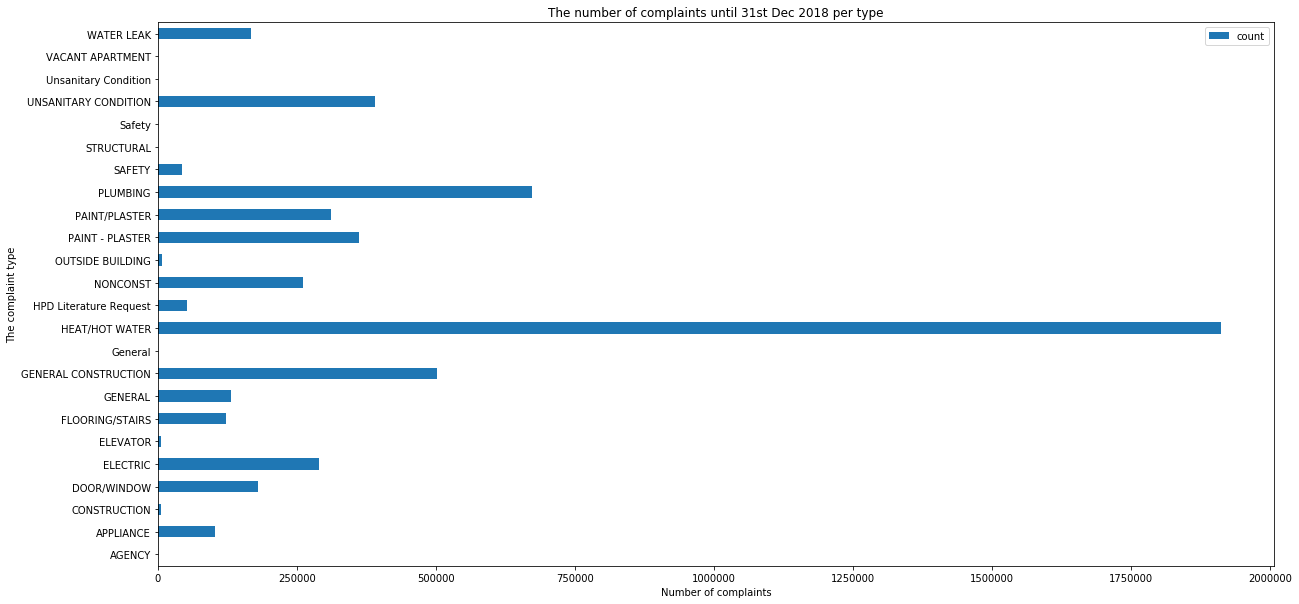

In [7]:
# Let us look at the distribution of the complaint type values
summary.plot(kind = "barh",
             figsize = (20,10))
plt.title('The number of complaints until 31st Dec 2018 per type')
plt.xlabel('Number of complaints')
plt.ylabel('The complaint type')
plt.show()
plt.close()

# Conlucisons

In this investigation we had to answer the question of:

> What Is the Top Complaint Type?

Our answe to the question is as follows:

According to the Table statistics and the presented Bar chart  the top complaint type is the **'HEAT/HOT WATER'** complaint which counts to **1910931** complaints until the 31st of December 2018.

The next in the list is the the **'PLUMBING'** complaint which counts to **673260** occasions and thus has to be handled as a second priority item.